## Importing necessary packages

In [36]:
import pandas as pd
import numpy as np
import scipy as sc
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

## Loading Files

In [37]:
playcount_df = pd.read_csv('10kusers_500songs.csv')
song_info = pd.read_csv('song_info.csv')
genre = pd.read_csv('genre.csv')

In [38]:
playcount_df.head()

,user_id,song_id,listen_count
0,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOUKXIN12A8C133C7F,3
1,1d04a4f845e6028b133cdb00afac4ab9c0bf422e,SOUKXIN12A8C133C7F,2
2,1ed24d0082434d4147ae3831d948a9b7738123ae,SOUKXIN12A8C133C7F,6
3,63abe7cbc1d2c45ba385e1332ec07e735269aed7,SOUKXIN12A8C133C7F,1
4,5ed13deffe791a7b2109e1d56ea847b99b6dd4af,SOUKXIN12A8C133C7F,2


In [39]:
song_info.head()

,song_id,track_id,artist_name,track_name
0,SOAAADD12AB018A9DD,TRNCENP12903C9EF3A,Harold Budd,The Room Of Stairs
1,SOAAADE12A6D4F80CC,TRSKKFK128F148B615,Dave Edmunds,(I'm Gonna Start) Living Again If It Kills Me ...
2,SOAAADF12A8C13DF62,TRCQMSP128F428A6F7,LANDA DANIEL,KRYSAR (LIVE)
3,SOAAADZ12A8C1334FB,TRMDNZY128F425A532,Paul Cardall,Joy To The World
4,SOAAAFI12A6D4F9C66,TRZEXLQ128F1491D17,I Love You But I've Chosen Darkness,The Less You See


In [40]:
genre.head()

,track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


## Merging Files to get all required information - only keeping songs that have genre information for this model

In [41]:
df_song_info = pd.merge(playcount_df, song_info, how='inner', on='song_id')
df_song_info_genre = pd.merge(df_song_info, genre, how='inner', on='track_id')

In [42]:
df_song_info_genre.head()

,user_id,song_id,listen_count,track_id,artist_name,track_name,genre
0,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOUKXIN12A8C133C7F,3,TRCUEPI128F4278E10,Incubus,Drive,Pop_Rock
1,1d04a4f845e6028b133cdb00afac4ab9c0bf422e,SOUKXIN12A8C133C7F,2,TRCUEPI128F4278E10,Incubus,Drive,Pop_Rock
2,1ed24d0082434d4147ae3831d948a9b7738123ae,SOUKXIN12A8C133C7F,6,TRCUEPI128F4278E10,Incubus,Drive,Pop_Rock
3,63abe7cbc1d2c45ba385e1332ec07e735269aed7,SOUKXIN12A8C133C7F,1,TRCUEPI128F4278E10,Incubus,Drive,Pop_Rock
4,5ed13deffe791a7b2109e1d56ea847b99b6dd4af,SOUKXIN12A8C133C7F,2,TRCUEPI128F4278E10,Incubus,Drive,Pop_Rock


## Creating mapping files to go from user, song, artist and genre to numeric identifiers for the model input

In [43]:
songs = df_song_info_genre['song_id'].unique()
users = df_song_info_genre['user_id'].unique()
genres = df_song_info_genre['genre'].unique()
artists = df_song_info_genre['artist_name'].unique()

In [44]:
# Users
user2idx = {u : i for i, u in enumerate(users)}
idx2user = {i : u for i, u in enumerate(users)}

# Songs
song2idx = {u : i for i, u in enumerate(songs)}
idx2song = {i : u for i, u in enumerate(songs)}

# Genre
genre2idx = {u : i for i, u in enumerate(genres)}
idx2genre = {i : u for i, u in enumerate(genres)}

# Artist
artist2idx = {u : i for i, u in enumerate(artists)}
idx2artist = {i : u for i, u in enumerate(artists)}

In [45]:
# User dict sample keys and values
{(k,v) for k,v in user2idx.items() if 0<v<=5}

{('1d04a4f845e6028b133cdb00afac4ab9c0bf422e', 1),
 ('1ed24d0082434d4147ae3831d948a9b7738123ae', 2),
 ('3f8a6d3a4cc7cd1a751e48b77ef808f4d35da27f', 5),
 ('5ed13deffe791a7b2109e1d56ea847b99b6dd4af', 4),
 ('63abe7cbc1d2c45ba385e1332ec07e735269aed7', 3)}

## Mapping user and song to numeric - for the first version, we are not using any genre or artist side information

In [46]:
df_ids = df_song_info_genre[['user_id', 'song_id', 'listen_count']]

In [47]:
df_ids['song_id'] = df_ids['song_id'].map(song2idx)
df_ids['user_id'] = df_ids['user_id'].map(user2idx)

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
df_ids.head()

,user_id,song_id,listen_count
0,0,0,3
1,1,0,2
2,2,0,6
3,3,0,1
4,4,0,2


## Splitting into Train, Validation and Test datasets

In [49]:
df_train, df_test = train_test_split(df_ids, train_size=0.8, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, train_size=0.8, test_size=0.2, random_state=42)

## Function to convert unstacked dataframe into a sparse matrix

In [50]:
def convert_to_sparse_matrix(df, mat_type='csr', rows='user_id', cols='song_id', val = 'listen_count', shape=(len(idx2user), len(idx2song))):
    df_matrix = np.zeros(shape=shape)
    for index, row in df.iterrows():
        df_matrix[row[rows], row[cols]] = row[val]

    if mat_type=='csr':
        df_matrix = sc.sparse.csr_matrix(df_matrix)
    elif mat_type=='coo':
        df_matrix = sc.sparse.coo_matrix(df_matrix)

    return df_matrix

## Function to list top k recommendations from the model

In [115]:
def recommend_items(user, model, item_features, k=5):
    user_id_lkup = user2idx[user]
    
    known_positives = np.argsort(np.array(df_train_coo.todense()[user_id_lkup])).T[::-1][:k]
    known_positives = [idx2song[song_listened] for song_listened in list(known_positives.ravel())]
    
    print('Listened Songs:')

    for song_listened in known_positives:
        song = list(song_info[song_info['song_id']==song_listened][['artist_name', 'track_name']].iloc[0])
        print ('Artist:', song[0], '& Song:', song[1])
    
    predictions = model.predict(user_id_lkup, list(range(len(idx2song))), item_features=item_features)
    predictions_sorted = np.argsort(predictions)[::-1]
    pred_list = [idx2song[pred] for pred in predictions_sorted[:k]]
   
    print('')
    print('Recommended Songs:')

    for pred in pred_list:
        song = list(song_info[song_info['song_id']==pred][['artist_name', 'track_name']].iloc[0])
        print ('Artist:', song[0], '& Song:', song[1])

## Converting Train and Test Matrices to Sparse Matrices

In [51]:
df_train_coo = convert_to_sparse_matrix(df_train, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_val_coo = convert_to_sparse_matrix(df_val, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_test_coo = convert_to_sparse_matrix(df_test, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))

## Using reciprocal rank to determine number of components to use (parameter tuning)
### Reciprocal Rank is calculated using the formula: 1 / the rank of the highest ranked positive example. A perfect score is 1.0.

In [52]:
perf_metrics = {}
for n_components in range(1,26):
    perf_metrics[n_components] = {}
    model = LightFM(no_components=n_components, k=10, loss='warp')
    model.fit(df_train_coo, epochs=10)
    perf_metrics[n_components]['n_precision_at_k'] = int(sum(precision_at_k(model, df_val_coo)*10))
    perf_metrics[n_components]['mean_precision_at_k'] = np.mean(precision_at_k(model, df_val_coo))
    perf_metrics[n_components]['mean_recall_at_k'] = np.mean(recall_at_k(model, df_val_coo))
    perf_metrics[n_components]['mean_auc'] = np.mean(auc_score(model, df_val_coo))
    perf_metrics[n_components]['reciprocal_rank'] = np.mean(reciprocal_rank(model, df_val_coo))

In [53]:
metrics_df = pd.DataFrame(perf_metrics).T

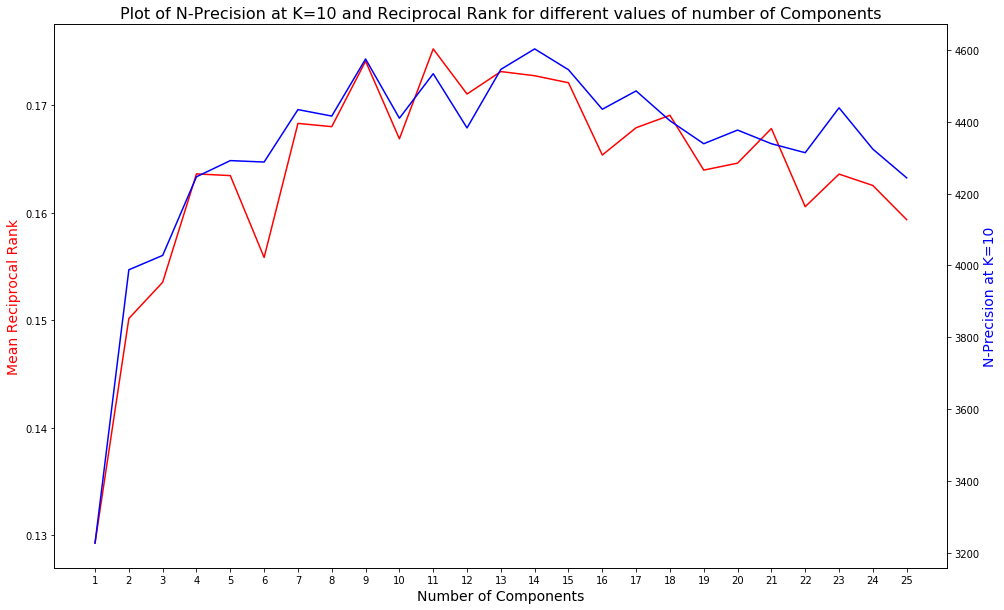

In [59]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Mean Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [56]:
print('Highest Reciprocal Rank achieved at {} components'.format(np.argmax(metrics_df['reciprocal_rank'])))
print('Highest N-Precision at K=10 Rank achieved at {} components'.format(np.argmax(metrics_df['n_precision_at_k'])))

Highest Reciprocal Rank achieved at 11 components
Highest N-Precision at K=10 Rank achieved at 14 components


## Based on the above metrics, we can use 9 components for this dataset

In [245]:
model = LightFM(no_components=9, k=10, loss='warp')
model.fit(df_train_coo, epochs=10)

## Evaluating on the test dataset

In [58]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo))))

Number of listened predictions across all users: 5404
Mean reciprocal rank across all users: 0.189
Mean auc score across all users: 0.772


## We notice that the AUC is close to 0.8 which indicates that the model ranks positive items higher than negative items for users - from a ranking standpoint, this is good. 
## The reciprocal rank is ~0.2. While that might sound low, we have a lot of items to recommend to the user and narowing down such that we have a listened song in the top 5 recommendations made is pretty good.

## Testing out the Recommendations for a random user

In [246]:
recommend_items('c51ff54138c508b897d4ed3b9d099e76dbec880a', model, None)

Listened Songs:
Artist: John Mayer & Song: Heartbreak Warfare
Artist: Katy Perry & Song: Lost
Artist: MSTRKRFT & Song: Street Justice
Artist: Florence + The Machine & Song: You've Got The Love
Artist: Coldplay & Song: The Scientist

Recommended Songs:
Artist: Coldplay & Song: Clocks
Artist: Coldplay & Song: The Scientist
Artist: Kings Of Leon & Song: Revelry
Artist: Coldplay & Song: Shiver
Artist: Lady GaGa & Song: Alejandro


## We see that the recommendations are pretty interesting. There are songs from Coldplay which is an artist the user already listens to and there are other songs that also seem to be similar to songs the user listened to.

## Visualizing Item Embeddings after using TSNE for dimensionality reduction

In [67]:
from sklearn.manifold import TSNE

In [68]:
TSNE_model = TSNE(n_components=2, random_state=0)
embeddings = TSNE_model.fit_transform(model.item_embeddings)

## Genre Distribution

In [69]:
genre_list = pd.merge(pd.DataFrame(songs, columns=['song_id']), df_song_info_genre[['song_id', 'genre']].drop_duplicates(), on='song_id')['genre']

In [70]:
genre_list.value_counts()

Pop_Rock         226
Electronic        43
Folk              10
RnB                8
Rap                5
Country            3
Reggae             2
Comedy_Spoken      1
Jazz               1
Latin              1
Name: genre, dtype: int64

## We can see that the genre is dominated by pop_rock which isn't great - we would have liked to have it split out by pop and rock ideally but let's look at how they get embedded

## Genre Visualization

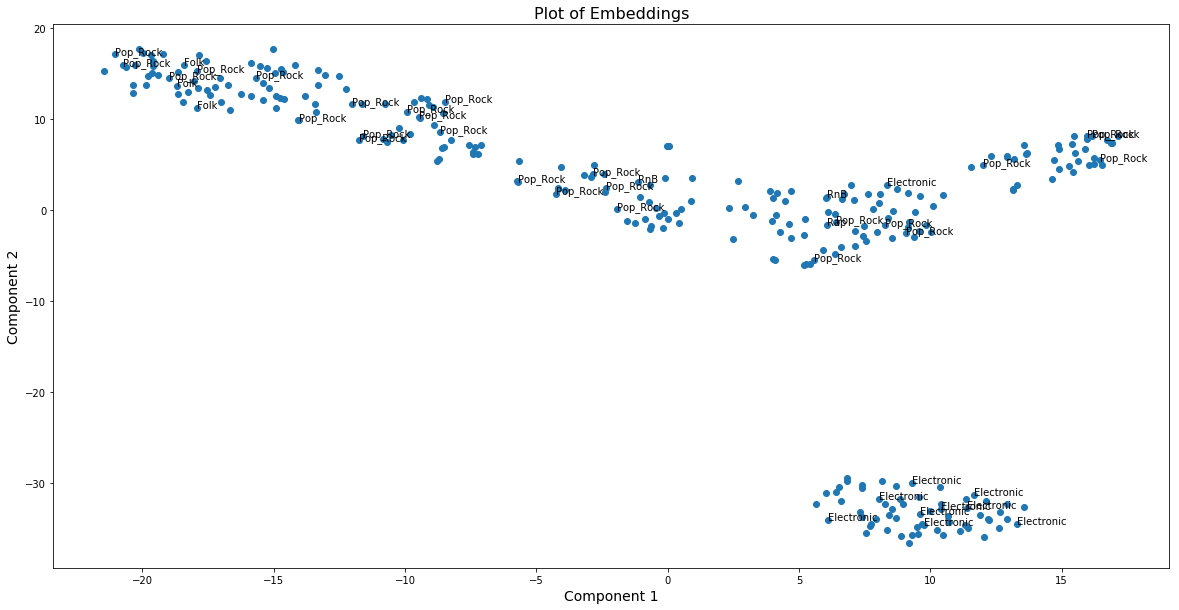

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(embeddings[:,0], embeddings[:,1])

for i, txt in enumerate(genre_list):
    if i in [239,241,41, 237, 199, 207, 43, 192, 25, 164, 120, 100, 135]+list(range(1,150,5)):
        ax.annotate(txt, (embeddings[:,0][i], embeddings[:,1][i]))
        
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.title('Plot of Embeddings', fontsize=16)
plt.show()

## We haven't fed any side information (genre) to the model. 
## Despite that, we can see that the item embeddings cluster around the genre - electronic songs have clustered together while pop_rock songs are more spread out because they cover a wide array. This plot would look better if we had more granular genre information

## Artist Distribution

In [72]:
artist_list = pd.merge(pd.DataFrame(songs, columns=['song_id']), df_song_info_genre[['song_id', 'artist_name']].drop_duplicates(), on='song_id')['artist_name']

In [73]:
artist_list.value_counts()[:10]

the bird and the bee    15
LCD Soundsystem         13
The Kills               12
Boys Noize              11
Foals                   11
Vampire Weekend         11
Coldplay                10
Metric                  10
Soltero                  9
Erin McKeown             9
Name: artist_name, dtype: int64

## Artist Visualization

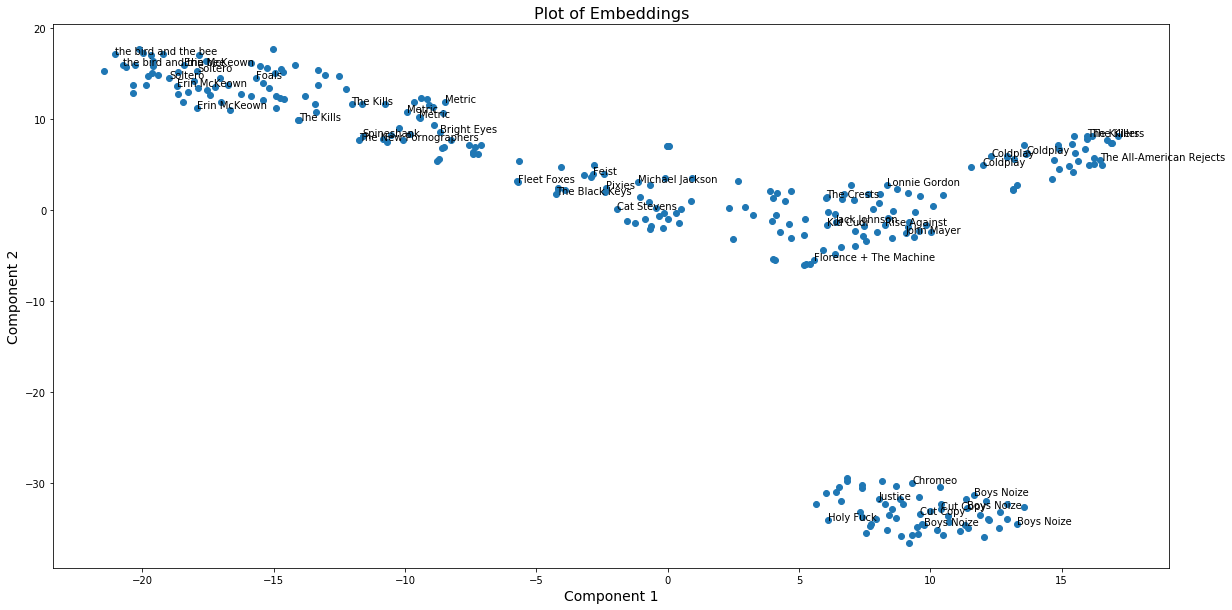

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(embeddings[:,0], embeddings[:,1])

for i, txt in enumerate(artist_list):
    if i in [239,241,41, 237, 199, 207, 43, 192, 25, 164, 120, 130, 100, 8, 135]+list(range(1,150,5)):
        ax.annotate(txt, (embeddings[:,0][i], embeddings[:,1][i]))
        
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.title('Plot of Embeddings', fontsize=16)
plt.show()

## It's very clear from the plot that songs from the same artist are very close to each other in the embedding space. This is expected but is interesting to see
## Also, it's good to see that Coldplay songs are close to the songs by The Killers - again, that is intuitive to us

## Adding Side Information and checking the performance

## Adding Genre First

In [75]:
song_genres = df_song_info_genre[['song_id', 'genre']].drop_duplicates()
song_genres['song_id'] = song_genres['song_id'].map(song2idx)
song_genres['genre'] = song_genres['genre'].map(genre2idx)
song_genres['onehot'] = 1

## Converting to CSR matrix as that is the expected input format for the LightFM Model

In [76]:
genre_csr = convert_to_sparse_matrix(song_genres, mat_type='csr', rows='song_id', cols='genre', val='onehot', shape=(len(idx2song), len(idx2genre)))

In [77]:
perf_metrics = {}
for n_components in range(1,26):
    perf_metrics[n_components] = {}
    model = LightFM(no_components=n_components, k=10, loss='warp')
    model.fit(df_train_coo, epochs=10, item_features=genre_csr)
    perf_metrics[n_components]['n_precision_at_k'] = int(sum(precision_at_k(model, df_val_coo, item_features=genre_csr)*10))
    perf_metrics[n_components]['mean_precision_at_k'] = np.mean(precision_at_k(model, df_val_coo, item_features=genre_csr))
    perf_metrics[n_components]['mean_recall_at_k'] = np.mean(recall_at_k(model, df_val_coo, item_features=genre_csr))
    perf_metrics[n_components]['mean_auc'] = np.mean(auc_score(model, df_val_coo, item_features=genre_csr))
    perf_metrics[n_components]['reciprocal_rank'] = np.mean(reciprocal_rank(model, df_val_coo, item_features=genre_csr))

In [78]:
metrics_df = pd.DataFrame(perf_metrics).T

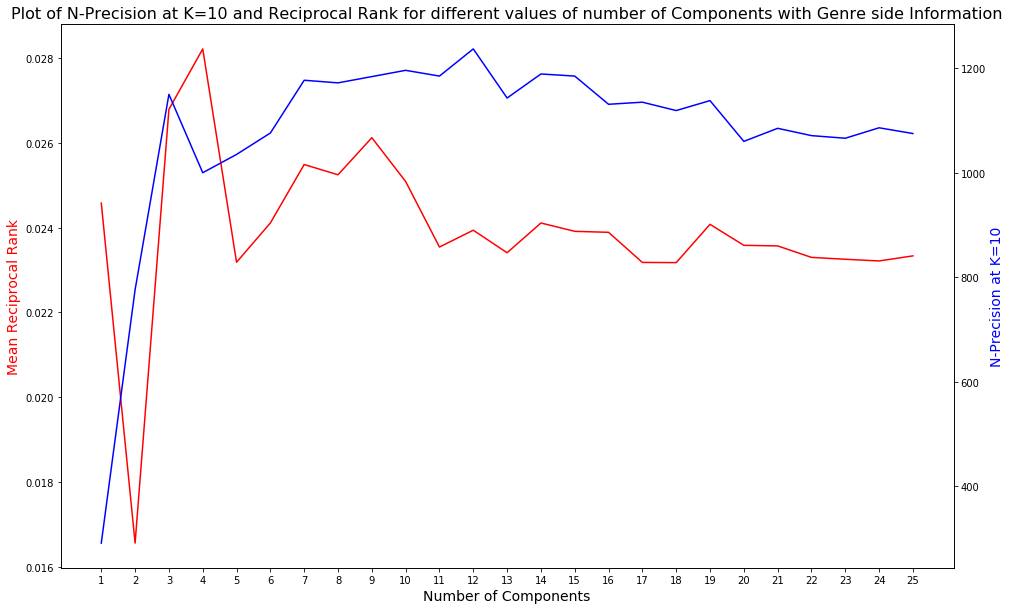

In [85]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Mean Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components with Genre side Information', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [80]:
print('Highest Reciprocal Rank achieved at {} components'.format(np.argmax(metrics_df['reciprocal_rank'])))
print('Highest N-Precision at K=10 Rank achieved at {} components'.format(np.argmax(metrics_df['n_precision_at_k'])))

Highest Reciprocal Rank achieved at 4 components
Highest N-Precision at K=10 Rank achieved at 12 components


## Based on the above metrics, we can use 9 components for this dataset

In [83]:
model = LightFM(no_components=7, k=10, loss='warp')
model.fit(df_train_coo, epochs=10, item_features=genre_csr)

## Evaluating on the test dataset

In [84]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=genre_csr)*10)))
print("Mean reciprocal rank across all users:: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=genre_csr))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=genre_csr))))

Number of listened predictions across all users: 1534
Mean reciprocal rank across all users:: 0.027
Mean auc score across all users: 0.265


## It's clear that the addition of genre made the model worse. This could be because the genre is not very granular

## Repeating the same for artist and the full item matrix (artist + genre)

## Adding Artist Information

In [86]:
song_artists = df_song_info_genre[['song_id', 'artist_name']].drop_duplicates()
song_artists['song_id'] = song_artists['song_id'].map(song2idx)
song_artists['artist'] = song_artists['artist_name'].map(artist2idx)
song_artists['onehot'] = 1

## Converting to CSR matrix as that is the expected input format for the LightFM Model

In [87]:
artist_csr = convert_to_sparse_matrix(song_artists, mat_type='csr', rows='song_id', cols='artist', val='onehot', shape=(len(idx2song), len(idx2artist)))

In [88]:
perf_metrics = {}
for n_components in range(1,26):
    perf_metrics[n_components] = {}
    model = LightFM(no_components=n_components, k=10, loss='warp')
    model.fit(df_train_coo, epochs=10, item_features=artist_csr)
    perf_metrics[n_components]['n_precision_at_k'] = int(sum(precision_at_k(model, df_val_coo, item_features=artist_csr)*10))
    perf_metrics[n_components]['mean_precision_at_k'] = np.mean(precision_at_k(model, df_val_coo, item_features=artist_csr))
    perf_metrics[n_components]['mean_recall_at_k'] = np.mean(recall_at_k(model, df_val_coo, item_features=artist_csr))
    perf_metrics[n_components]['mean_auc'] = np.mean(auc_score(model, df_val_coo, item_features=artist_csr))
    perf_metrics[n_components]['reciprocal_rank'] = np.mean(reciprocal_rank(model, df_val_coo, item_features=artist_csr))

In [89]:
metrics_df = pd.DataFrame(perf_metrics).T

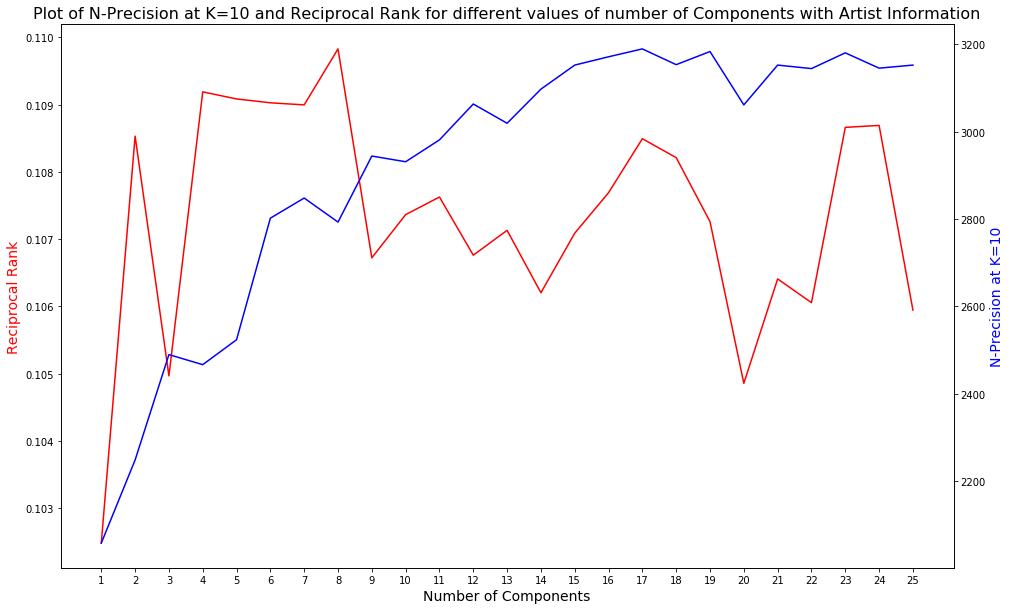

In [90]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components with Artist Information', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [94]:
print('Highest Reciprocal Rank achieved at {} components'.format(np.argmax(metrics_df['reciprocal_rank'])))
print('Highest N-Precision at K=10 Rank achieved at {} components'.format(np.argmax(metrics_df['n_precision_at_k'])))

Highest Reciprocal Rank achieved at 8 components
Highest N-Precision at K=10 Rank achieved at 17 components


## Based on the above metrics, we can use 16 components for this dataset

In [117]:
model = LightFM(no_components=16, k=10, loss='warp')
model.fit(df_train_coo, epochs=10, item_features=artist_csr)

## Evaluating on the test dataset

In [96]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=artist_csr)*10)))
print("Mean reciprocal rank across all users:: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=artist_csr))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=artist_csr))))

Number of listened predictions across all users: 3967
Mean reciprocal rank across all users:: 0.122
Mean auc score across all users: 0.779


## The performance is better than when we use only genre but it is still isn't as good as the performance we obtained without side information

## Adding both Artist and Genre

## Creating the full item feature matrix by combining artist and genre

In [97]:
full_item_features_csr = sc.sparse.csr_matrix(np.hstack((genre_csr.todense(), artist_csr.todense())))

In [98]:
perf_metrics = {}
for n_components in range(1,26):
    perf_metrics[n_components] = {}
    model = LightFM(no_components=n_components, k=10, loss='warp')
    model.fit(df_train_coo, epochs=10, item_features=full_item_features_csr)
    perf_metrics[n_components]['n_precision_at_k'] = int(sum(precision_at_k(model, df_val_coo, item_features=full_item_features_csr)*10))
    perf_metrics[n_components]['mean_precision_at_k'] = np.mean(precision_at_k(model, df_val_coo, item_features=full_item_features_csr))
    perf_metrics[n_components]['mean_recall_at_k'] = np.mean(recall_at_k(model, df_val_coo, item_features=full_item_features_csr))
    perf_metrics[n_components]['mean_auc'] = np.mean(auc_score(model, df_val_coo, item_features=full_item_features_csr))
    perf_metrics[n_components]['reciprocal_rank'] = np.mean(reciprocal_rank(model, df_val_coo, item_features=full_item_features_csr))

In [99]:
metrics_df = pd.DataFrame(perf_metrics).T

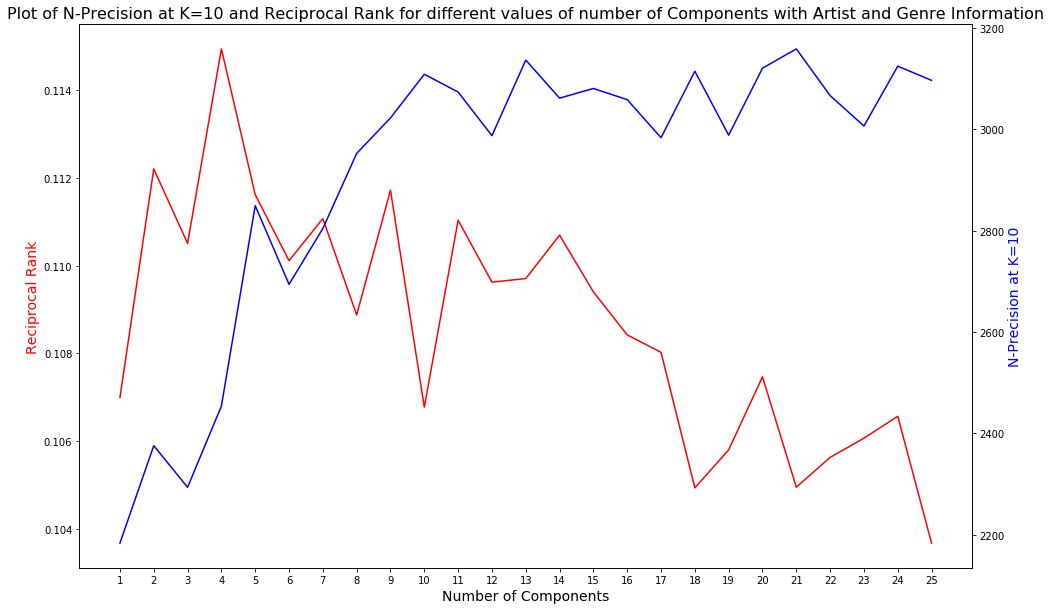

In [100]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components with Artist and Genre Information', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [101]:
print('Highest Reciprocal Rank achieved at {} components'.format(np.argmax(metrics_df['reciprocal_rank'])))
print('Highest N-Precision at K=10 Rank achieved at {} components'.format(np.argmax(metrics_df['n_precision_at_k'])))

Highest Reciprocal Rank achieved at 4 components
Highest N-Precision at K=10 Rank achieved at 21 components


## Based on the above metrics, we can use 13 components for this dataset - the variation is reciprocal rank is not too much lower at 13 components compared to 2 components

In [120]:
model = LightFM(no_components=15, k=10, loss='warp')
model.fit(df_train_coo, epochs=10, item_features=full_item_features_csr)

## Evaluating on the test dataset

In [104]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=full_item_features_csr)*10)))
print("Mean reciprocal rank across all users:: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=full_item_features_csr))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=full_item_features_csr))))

Number of listened predictions across all users: 4061
Mean reciprocal rank across all users:: 0.122
Mean auc score across all users: 0.776


## The performance with both genre and artist information is still not as good as the performance without side information

## Testing out the Recommendations for the same user

In [121]:
recommend_items('c51ff54138c508b897d4ed3b9d099e76dbec880a', model, full_item_features_csr)

Listened Songs:
Artist: John Mayer & Song: Heartbreak Warfare
Artist: Katy Perry & Song: Lost
Artist: MSTRKRFT & Song: Street Justice
Artist: Florence + The Machine & Song: You've Got The Love
Artist: Coldplay & Song: The Scientist

Recommended Songs:
Artist: La Roux & Song: Bulletproof
Artist: Muse & Song: Resistance
Artist: Muse & Song: Uprising
Artist: Miley Cyrus & Song: Party In The U.S.A.
Artist: Five Iron Frenzy & Song: Canada


## We see that the recommendations are quite different from the ones we had with the model without side information. However, they are still relevant to the user

## Calculation of the Baseline Metrics

In [226]:
def baseline_top_items_n_precision_at_k(df_train_coo, df_test_coo, k):
    top_songs_indices = np.argsort((np.where(df_train_coo.todense()>0, 1, 0)).sum(axis=0))[::-1]
    df_test_pred = np.zeros_like(df_test_coo.todense())
    for val in top_songs_indices[:k]:
        df_test_pred[:,val] = 1
    listened_songs = np.where(df_test_coo.todense()>0, 1, 0)
    baseline_n_precision_at_k = (np.multiply(df_test_pred, listened_songs)).sum()
    
    return baseline_n_precision_at_k

In [252]:
print ('Baseline number of listened predictions across all users: {0:.0f}'.format(baseline_top_items_n_precision_at_k(df_train_coo=df_train_coo, df_test_coo=df_test_coo, k=10)))

Baseline number of listened predictions across all users: 3031


In [230]:
def baseline_top_items_reciprocal_rank(df_train_coo, df_test_coo):
    top_songs_indices = np.argsort((np.where(df_train_coo.todense()>0, 1, 0)).sum(axis=0))[::-1]
    recip_rank_baseline = []
    for user in range(df_test_coo.shape[0]):
        listened_songs_user_indices = np.argwhere(df_test_coo.todense()[user])[:,1]
        if len(listened_songs_user_indices>0):
            rank = min([np.argwhere(top_songs_indices==val) for val in listened_songs_user_indices])+1
            recip_rank_baseline.append(1.0/rank)
        else: recip_rank_baseline.append(0)
    return np.mean(recip_rank_baseline)[0][0]

In [253]:
print ('Baseline Mean Reciprocal Rank across all users: {0:.3f}'.format(baseline_top_items_reciprocal_rank(df_train_coo=df_train_coo, df_test_coo=df_test_coo)))

Baseline Mean Reciprocal Rank across all users: 0.099
